In [165]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation


from time import sleep
import time
import math

from PIL import Image
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


## LSTM

## Реализация на PyToch
##### https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [506]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, inputs):
        x = inputs
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

https://github.com/shahroudy/NTURGB-D

#### Classes:
* sitting down
* clapping
* jump up
* cheer up
* hand waving

In [167]:
# skeletons = pd.read_csv("skels.csv")
skeletons = pd.read_csv("test_01.csv")

In [168]:
LABELS = {0: "sit down", 1: "clapping", 2:  "cheer up", 3: "hand waving", 4: "jump up", 
          5: "take off a hat", 6: "writing", 7: "put on glasses", 8: "tear up paper"}

In [169]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103227,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496548,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1
2,0.233268,0.182226,3.738342,0.246664,0.427726,3.664138,0.258953,0.668395,3.579175,0.232204,...,0.341380,0.398297,3.464900,0.086362,0.484182,3.377581,0.137638,0.470977,3.347150,2
3,0.224168,0.188563,3.735721,0.225902,0.421312,3.664325,0.227259,0.649151,3.583410,0.194906,...,0.177972,0.426407,3.417228,0.066224,0.472247,3.390802,0.108203,0.448698,3.364467,2
4,0.229684,0.188112,3.749971,0.242151,0.432106,3.679358,0.252508,0.670998,3.597336,0.229758,...,-0.079222,0.348027,3.337667,0.085692,0.430705,3.427691,0.157289,0.475443,3.425417,3


## Dataloader

``` DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None) ```

Класс Dataset и класс Dataloader помогают передавать собственные обучающие данные в сеть. 
Класс Dataset используется для обеспечения интерфейса для доступа ко всем обучающим или тестовым образцам в вашем наборе данных. Для этого необходимо реализовать как два обязательных метода, __getitem__ и __len_. 

In [777]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [791]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, n_kadr=45, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.n_kadr = n_kadr


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.n_kadr,75)
        label = self.data.iloc[idx,-1]

        if self.transform != None:
            item = self.transform(item).reshape(self.n_kadr,75)
        return (item, label)

transform_it = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=0.5, std=0.5)
    ])

In [792]:
normalize = True
# file = "skels.csv"
# file = "test_01.csv"
# n_kadr = 45
file = "test_02_35k.csv"
n_kadr = 35
# file = "test_02_25k.csv"
# n_kadr = 25

In [794]:
if normalize:
    dataset = Skeleton_Dataset(file_path=file, n_kadr=n_kadr, transform=transform_it)
    skel, lab = dataset.__getitem__(41)
    sket_tensor = skel.float()
else:
    dataset = Skeleton_Dataset(file_path=file, n_kadr=n_kadr, transform=None)
    skel, lab = dataset.__getitem__(41)
    sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()

In [795]:
skel.shape, sket_tensor.size(), type(skel)

(torch.Size([35, 75]), torch.Size([35, 75]), torch.Tensor)

In [796]:
skel

tensor([[-0.4393, -0.7528,  6.1467,  ..., -0.7650, -0.2972,  5.4252],
        [-0.4393, -0.7528,  6.1465,  ..., -0.8271, -0.2938,  5.4395],
        [-0.4393, -0.7527,  6.1460,  ..., -0.7995, -0.3061,  5.4122],
        ...,
        [-0.4430, -0.7669,  6.1257,  ..., -0.7477, -0.2704,  5.4344],
        [-0.4446, -0.7681,  6.1268,  ..., -0.7470, -0.2748,  5.4506],
        [-0.4416, -0.7696,  6.1245,  ..., -0.7305, -0.2961,  5.4250]],
       dtype=torch.float64)

In [797]:
type(lab), LABELS[lab], lab

(numpy.int64, 'hand waving', 3)

In [798]:
train_len = int(0.7*len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset)-train_len])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [799]:
n_hidden = 96
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 96, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=96, out_features=9, bias=True)
)

In [800]:
output = rnn(sket_tensor.to(device))

RuntimeError: input must have 3 dimensions, got 2

In [801]:
output.topk(9)

torch.return_types.topk(
values=tensor([[ 0.0906,  0.0690,  0.0664,  0.0566,  0.0421,  0.0171,  0.0132, -0.0783,
         -0.0996]], grad_fn=<TopkBackward>),
indices=tensor([[1, 8, 4, 5, 0, 6, 7, 3, 2]]))

In [802]:
len(train_loader)

53

In [803]:
for i, data in enumerate(train_loader, 0):
    if i % 440 == 0:
        print(i, data[0].size())
        print(i, data[1].size())

0 torch.Size([16, 35, 75])
0 torch.Size([16])


1. Необходимо нормализовать данные в датасете: написать функцию нормализации и использовать ее внутри класса датасета.

Для скорости тестирования обучал 150 эпох

In [804]:
%%time
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
momentum = 0.9
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
epoches = 150
data_whole = len(train_loader.dataset)*epoches

all_losses = []
start = time.time()
counter = 0
for epoch in range(epoches):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            data_done = i * len(inputs) + (epoch-1) * len(train_loader.dataset)
            if data_done < 0:
                data_done = 0
            data_done_perc = round(100. * data_done / data_whole, 1)

            print(f'epoch : {epoch} iter : {i} ({timeSince(start)}) / \
data done: {data_done_perc}% from {data_whole} / \
loss: {round(float(loss),4)} / {guess} {correct}')
#             print(output.topk(5))
#             print(labels.topk(5))
            all_losses.append(current_loss / 25)
        counter = counter + 1
        
#         if counter % 300 == 0:
#             print(all_losses[-1])
#     print(counter)
#         current_loss = 0

epoch : 0 iter : 0 (0m 0s) / data done: 0.0% from 126900 / loss: 2.2537 / writing ✗ (tear up paper)
epoch : 9 iter : 23 (0m 28s) / data done: 5.6% from 126900 / loss: 2.1269 / writing ✗ (cheer up)
epoch : 18 iter : 46 (0m 56s) / data done: 11.9% from 126900 / loss: 2.0449 / writing ✗ (jump up)
epoch : 28 iter : 16 (1m 23s) / data done: 18.2% from 126900 / loss: 1.8802 / cheer up ✓
epoch : 37 iter : 39 (1m 52s) / data done: 24.5% from 126900 / loss: 1.6837 / writing ✗ (clapping)
epoch : 47 iter : 9 (2m 22s) / data done: 30.8% from 126900 / loss: 1.6496 / clapping ✗ (jump up)
epoch : 56 iter : 32 (2m 51s) / data done: 37.1% from 126900 / loss: 1.3768 / sit down ✓
epoch : 66 iter : 2 (3m 21s) / data done: 43.4% from 126900 / loss: 1.2212 / tear up paper ✓
epoch : 75 iter : 25 (3m 51s) / data done: 49.6% from 126900 / loss: 1.2277 / put on glasses ✓
epoch : 84 iter : 48 (4m 22s) / data done: 55.9% from 126900 / loss: 1.1628 / sit down ✓
epoch : 94 iter : 18 (4m 52s) / data done: 62.2% from

__Результаты нормализации:__

Нормализация существенно уменьшило loss без изменения других параметров.

Кадров: 35, эпох: 150, lr: 0.0007, momentum: 0.9, last loss: 1.0997116184234619


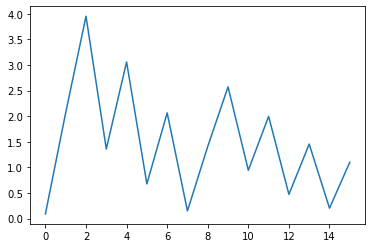

In [805]:
# Обучение итоговой модели длилось 7,5 минут
print(f'Кадров: {n_kadr}, эпох: {epoches}, lr: {learning_rate}, momentum: {momentum}, last loss: {all_losses[-1]}')
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

2. Приложен ноутбук в котором генерируется из большого датасета меньшая его копия. Вам нужно:
    
    a. Сгенерировать меньший датасет из 8-10 классов движения

__Сделал 2 дополнительных датасета - 25 и 35 кадров__

    b. Изменить функцию разбиения датасета на тестовую и тренировочную часть, увеличив кусок, отводимый на тест

__Увеличил размер тестового датасета выше__
    
    c. Обучить уже существующую модель (предварительно проанализировав какие параметры нужно менять)
    d. Изменить модель для улучшения качества
    e. Сгенерировать другой датасет с меньшим количеством “кадром” в нашей серии и сравнить с улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению кадров, назвать оптимальное, на ваш взгляд, их количество.
__Ниже улучшил качество модели и провел тестирование с разным кол-вом кадров:__

In [514]:
%%time
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
momentum = 0.9
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
epoches = 150
data_whole = len(train_loader.dataset)*epoches

all_losses = []
start = time.time()
counter = 0
for epoch in range(epoches):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            data_done = i * len(inputs) + (epoch-1) * len(train_loader.dataset)
            if data_done < 0:
                data_done = 0
            data_done_perc = round(100. * data_done / data_whole, 1)

            print(f'epoch : {epoch} iter : {i} ({timeSince(start)}) / \
data done: {data_done_perc}% from {data_whole} / \
loss: {round(float(loss),4)} / {guess} {correct}')
            all_losses.append(current_loss / 25)
        counter = counter + 1

epoch : 0 iter : 0 (0m 0s) / data done: 0.0% from 126900 / loss: 2.2287 / writing ✗ (hand waving)
epoch : 9 iter : 23 (0m 27s) / data done: 5.6% from 126900 / loss: 2.1959 / writing ✗ (clapping)
epoch : 18 iter : 46 (0m 54s) / data done: 11.9% from 126900 / loss: 2.172 / put on glasses ✓
epoch : 28 iter : 16 (1m 24s) / data done: 18.2% from 126900 / loss: 2.0357 / sit down ✗ (clapping)
epoch : 37 iter : 39 (1m 52s) / data done: 24.5% from 126900 / loss: 2.119 / writing ✗ (tear up paper)
epoch : 47 iter : 9 (2m 19s) / data done: 30.8% from 126900 / loss: 1.7699 / hand waving ✗ (cheer up)
epoch : 56 iter : 32 (2m 49s) / data done: 37.1% from 126900 / loss: 1.8282 / jump up ✓
epoch : 66 iter : 2 (3m 17s) / data done: 43.4% from 126900 / loss: 1.3784 / hand waving ✗ (clapping)
epoch : 75 iter : 25 (3m 46s) / data done: 49.6% from 126900 / loss: 1.4998 / take off a hat ✗ (jump up)
epoch : 84 iter : 48 (4m 15s) / data done: 55.9% from 126900 / loss: 1.4672 / take off a hat ✗ (jump up)
epoch 

__Результат экспериментов с параметрами модели для увеличения качества:__

- В первую очередь я включил параметр nesterov=True, который немного уменьшил loss. 
- Уменьшение кол-ва нейронов с 128 до 96 привело к небольшому уменьшению времени обучения без особого выигрыша в качестве модели. Но дополнительное включение слоя dropout уменьшило заметно loss.
- Увеличение кол-ва внутренних слоев с 2-х до 5-ти конечно же увеличело существенно время обучения, а на качестве отразилось отрицательно. Уменьшение кол-ва слоев до 1-го тоже не дало положительного результата в качестве.
- Я также попробовал разные уровни дропаута - 0.25 подошло лучше всего

#### Итоговая модель: 2 слоя, 96 нейрона, включен слой дропаут, без нормализации. 
#### Accuracy увеличилось с 52.17 до 78,26 для 150 эпох.
#### График:

Кадров: 35, эпох: 150, lr: 0.0007, momentum: 0.9, last loss: 1.1864256167411804


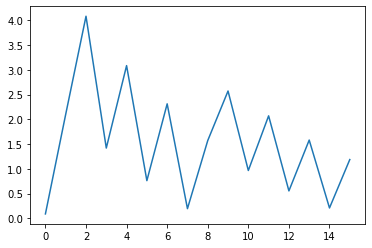

In [515]:
# Обучение итоговой модели длилось 7,5 минут
print(f'Кадров: {n_kadr}, эпох: {epoches}, lr: {learning_rate}, momentum: {momentum}, last loss: {all_losses[-1]}')
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [516]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   78.26086956521739


__Результат экспериментов с кол-вом кадров:__ 

При уменьшении кол-ва кадров с 45 до 35 loss уменьшился и время на обучение тоже существенно снизилось (с 13 до 8 минут). Дальнейшее уменьшение с 35 до 25 кадров не привело к существенному уменьшению времени (с 8 до 7 минут), а loss вырос. Можно сказать, что кол-во кадров - это гиперпараметр нейронной сети, который нужно подбирать. Чем меньше его делать, тем выше будет скорость обучения.

Тестировал все на 150 эпохах для скорости.

Кадров: 25, эпох: 150, lr: 0.0007, momentum: 0.9, min loss: 2.7391418504714964


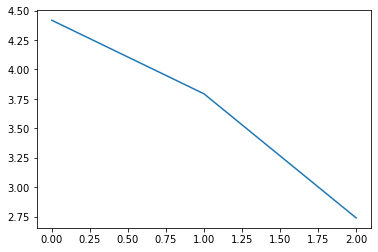

In [259]:
#Обучение с 25 кадрами длилось 7 минут
print(f'Кадров: {n_kadr}, эпох: {epoches}, lr: {learning_rate}, momentum: {momentum}, min loss: {min(all_losses)}')
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

Кадров: 35, эпох: 150, lr: 0.0007, momentum: 0.9, min loss: 0.08906577110290527


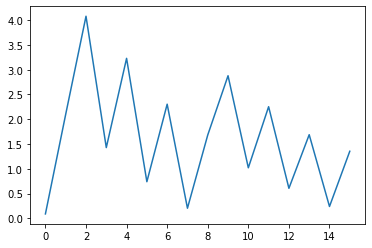

In [345]:
#Обучение с 35 кадрами длилось 8 минут
print(f'Кадров: {n_kadr}, эпох: {epoches}, lr: {learning_rate}, momentum: {momentum}, min loss: {min(all_losses)}')
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

Эпох: 150, lr: 0.0007, momentum: 0.9, min loss: 1.9925461602210999


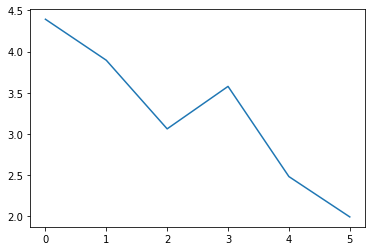

In [205]:
#Обучение c 45 кадрами длилось 13 минут
print(f'Эпох: {epoches}, lr: {learning_rate}, momentum: {momentum}, min loss: {min(all_losses)}')
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()